In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

from PIL import Image
import wandb

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "../../data/train/DCM"
LABEL_ROOT = "../../data/train/outputs_json"

In [3]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [4]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

print(len(pngs) , len(jsons))
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

pngs = sorted(pngs)
jsons = sorted(jsons)

800 800


In [5]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)

        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]

        # dummy label
        ys = [0 for fname in _filenames]

        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)

        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue

                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])

            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])

                # skip i > 0
                break

        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)

        image = cv2.imread(image_path)
        image = image / 255.

        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)

        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)

        # label 파일을 읽습니다.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]

        # 클래스 별로 처리합니다.
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])

            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label

        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)

            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
        label = label.transpose(2, 0, 1)

        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()

        return image_name,image, label

In [6]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)

    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]

    return image

In [14]:
tf = A.Resize(512, 512)
train_dataset = XRayDataset(is_train=True, transforms=tf)
valid_dataset = XRayDataset(is_train=False, transforms=tf)

image_name, image, label = train_dataset[0]

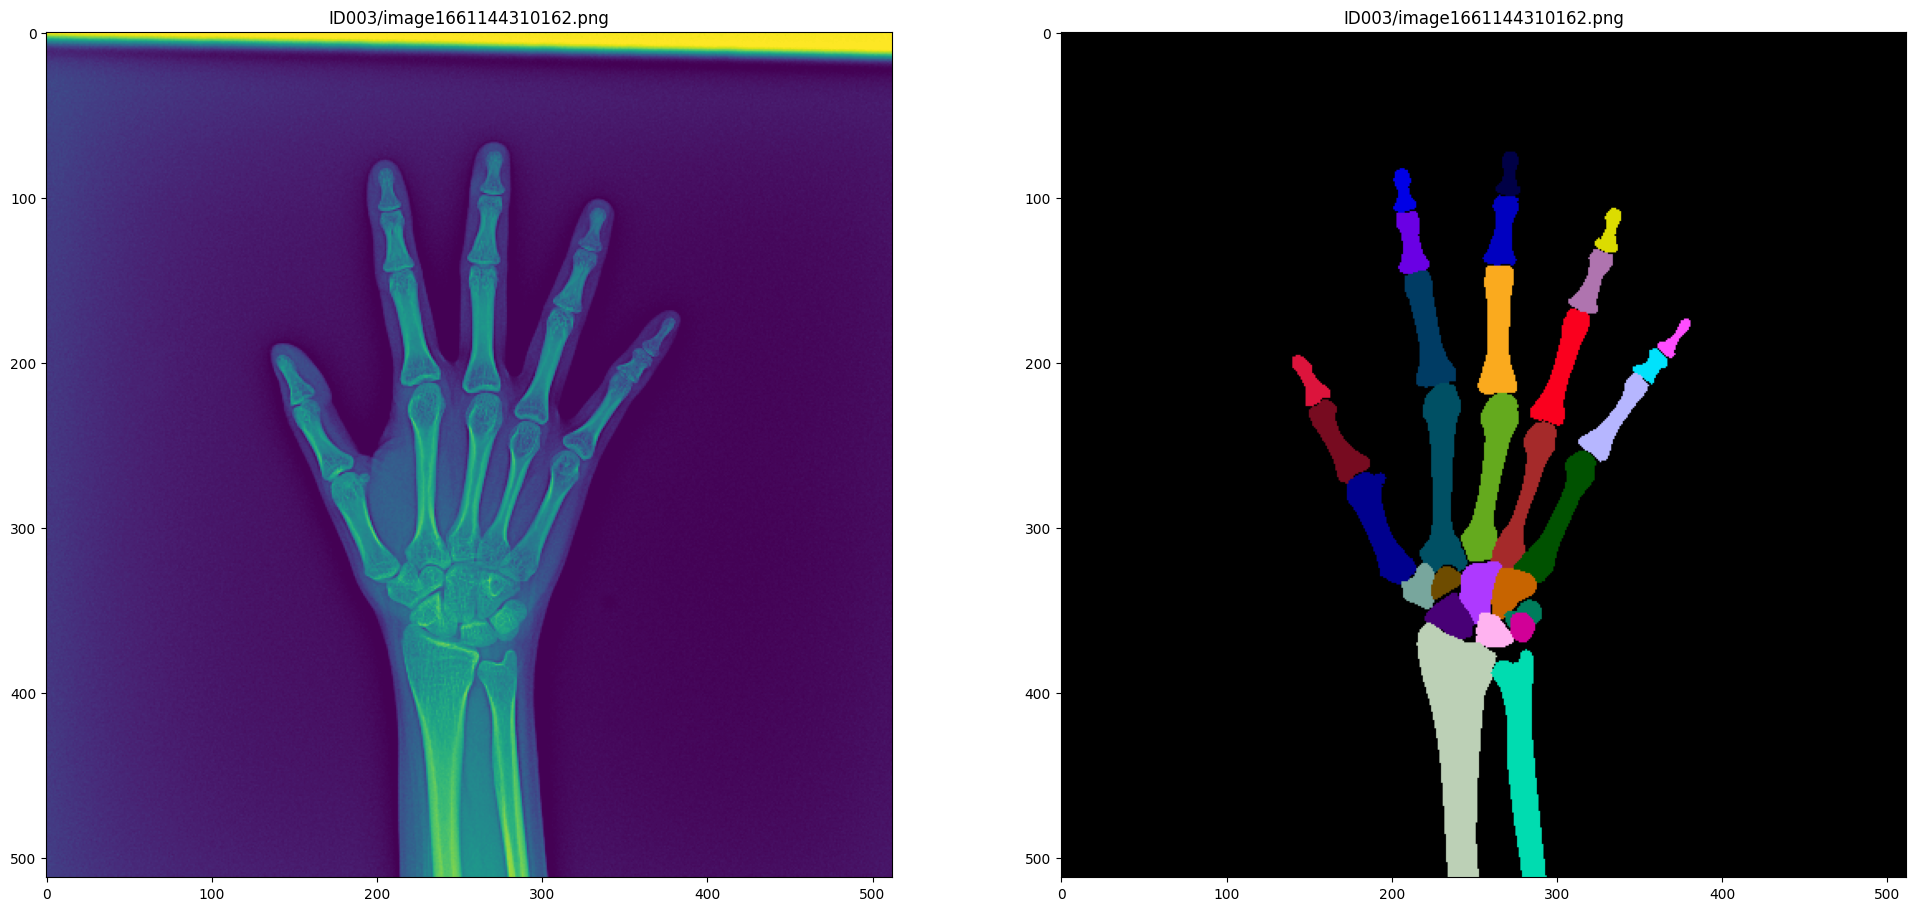

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].set_title(image_name)
ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
ax[1].set_title(image_name)
ax[1].imshow(label2rgb(label))

plt.show()

In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=8,
    drop_last=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [17]:
def ready_for_visualize(image, label):
    lbl = label.numpy().astype(np.uint8)
    img = image.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)  # [C, H, W] -> [H, W, C]로 변환
    return img, lbl 

### Mark 겹치지 않게 진행

In [18]:

class_groups = [
    [1, 4, 8, 12, 16, 20, 22, 26],  
    [2, 5, 9, 13, 17, 23, 24, 29],  
    [3, 6, 10, 14, 18, 21, 27, 28], 
    [11, 19, 25],  
    [7, 15]
]

class_group_label = [
    'Trapezium, Capitate, Triquetrum',
    'Hamate, Scaphoid, Ulna',
    'Trapezoid, Pisiform, Radius',
    '11, 19, Lunate',
    '7, 15'
]

class_labels = [{} for _ in range(len(class_groups))]
for idx, class_group in enumerate(class_groups):
    for class_idx in class_group:
        class_labels[idx][class_idx]=CLASSES[class_idx-1]   

## Ground Truth Visulization

In [20]:
wandb.login()

wandb.init(project= "segmentation-project",name= "train_gt")
for image_names, images, labels in train_loader:
    for image_name, image, label in zip(image_names,images, labels):
        print(f"Uploading {image_name}...")
        img, gt = ready_for_visualize(image, label)

        combined_mask_gt = np.zeros(shape=(len(class_groups), input_size,input_size), dtype=np.uint8)  # Shape: (H, W)
        for group_id, group_classes in enumerate(class_groups):
            for class_index in group_classes:

                gt_mask = gt[class_index-1]
                combined_mask_gt[group_id][gt_mask == 1] = class_index  # lbl is 0-indexed, so subtract 1

        masks_gt = dict()

        for i, mask in enumerate(combined_mask_gt):
            masks_gt[class_group_label[i]] = dict(mask_data=mask,class_labels=class_labels[i])
        
        masked_image_gt = wandb.Image(img, masks=masks_gt, caption=image_name)      
        wandb.log({"GT Mask":masked_image_gt})
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Uploading ID033/image1661317693696.png...
Uploading ID438/image1666141363652.png...
Uploading ID541/image1667266436973.png...
Uploading ID489/image1666662267153.png...
Uploading ID383/image1665454683455.png...
Uploading ID134/image1662340289452.png...
Uploading ID007/image1661145193855.png...
Uploading ID531/image1667264727682.png...
Uploading ID308/image1664241445936.png...
Uploading ID418/image1666055793379.png...
Uploading ID062/image1661393737086.png...
Uploading ID380/image1665453534921.png...
Uploading ID097/image1661823372660.png...
Uploading ID317/image1664242662364.png...
Uploading ID306/image1664241319690.png...
Uploading ID336/image1664848452388.png...
Uploading ID311/image1664241629103.png...
Uploading ID087/image1661821482292.png...
Uploading ID030/image1661317062396.png...
Uploading ID293/image1664157316352.png...
Uploading ID050/image1661389690781.png...
Uploading ID507/image1666747678551.png...
Uploading ID522/image1667178183675.png...
Uploading ID400/image1665539233052

## Prediction Visulization

In [23]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)  
        
        image = torch.from_numpy(image).float()
            
        return image, image_name

In [24]:
def create_pred_mask_dict(csv_path, input_size):
    df = pd.read_csv(csv_path)
    mask_dict = {}
    # 29개의 개별 마스크
    for idx in range(0, len(df)//29):
        lst = df.values[(idx*29):(idx*29)+29]
        image_name = lst[0][0]
        if image_name not in mask_dict:
            mask_dict[image_name] = []

        for j in range(len(CLASSES)):

            rle = lst[j][2].split()
            mask = decode_rle_to_mask(rle, input_size)

            mask_dict[image_name].append(mask)
    print('mask creation from csv is done')
    return mask_dict

def decode_rle_to_mask(rle, input_size):
    s = list(map(int, rle))
    starts, lengths = s[0::2], s[1::2]
    starts = np.array(starts) - 1  # Convert to 0 indexing
    ends = starts + lengths
    img = np.zeros(input_size*input_size, dtype=np.uint8)
    for start, end in zip(starts, ends):
        img[start:end] = 1
    return img.reshape((input_size, input_size))

def ready_for_visualize(image, label = None):
    if label is not None:
        lbl = label.numpy().astype(np.uint8)
    else:
        lbl = None
    img = image.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)  # [C, H, W] -> [H, W, C]로 변환
    return img, lbl 


In [25]:

IMAGE_ROOT = "../../data/test/DCM"
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}
len(pngs)

288

In [26]:
tf = A.Resize(2048, 2048)
test_dataset = XRayInferenceDataset(transforms=tf)

In [27]:
csv_path = '/data/ephemeral/home/jinbong/baseline/output_unet++_diceiou.csv'
input_size = 2048
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)


In [28]:
mask_dict = create_pred_mask_dict(csv_path, input_size)
csv_compare = True

mask creation from csv is done


In [29]:
wandb.init(project= "segmentation-project",name= "test_pred")
for images, image_name in test_loader:
    for image, image_name in zip(images, image_name):

        print(f"Uploading {image_name}...")

        img, _ = ready_for_visualize(image)

        pred = None
        if csv_compare:
            pred = mask_dict.get(image_name.split('/')[-1], None)
            pred = {v : i for v, i in zip(CLASSES, pred)}
        combined_mask_pred = np.zeros(shape=(len(class_groups),input_size,input_size), dtype=np.uint8)  # Shape: (H, W)
        # Assign unique IDs to each group
        for group_id, group_classes in enumerate(class_groups):
            for class_index in group_classes:
                
                if pred is not None:                        
                    pred_mask = pred.get(CLASSES[class_index-1], None)
                    combined_mask_pred[group_id][pred_mask == 1] = class_index  # lbl is 0-indexed, so subtract 1

        masks_pred = dict()
        for i, mask in enumerate(combined_mask_pred):
            masks_pred[class_group_label[i]] = dict(mask_data=mask,class_labels=class_labels[i])
        masked_image_pred = wandb.Image(img, masks=masks_pred, caption=image_name)  
        wandb.log({"Pred Mask":masked_image_pred})
wandb.finish()    

Uploading ID040/image1661319116107.png...
Uploading ID040/image1661319145363.png...
Uploading ID041/image1661319356239.png...
Uploading ID041/image1661319390106.png...
Uploading ID042/image1661320372752.png...
Uploading ID042/image1661320397148.png...
Uploading ID043/image1661320538919.png...
Uploading ID043/image1661320557045.png...
Uploading ID044/image1661320671343.png...
Uploading ID044/image1661320722689.png...
Uploading ID045/image1661320864475.png...
Uploading ID045/image1661320892395.png...
Uploading ID046/image1661320944318.png...
Uploading ID046/image1661320972355.png...
Uploading ID047/image1661389291522.png...
Uploading ID047/image1661389310383.png...
Uploading ID048/image1661389524954.png...
Uploading ID048/image1661389553713.png...
Uploading ID049/image1661389595277.png...
Uploading ID049/image1661389621012.png...
Uploading ID068/image1661735854451.png...
Uploading ID068/image1661735882043.png...
Uploading ID137/image1662340967509.png...
Uploading ID137/image1662340984526

## Validation visulization & model check

In [30]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "../../data1/train/DCM"
LABEL_ROOT = "../../data1/train/outputs_json"

In [35]:

class_groups = [
    [1, 4, 8, 12, 16, 20, 22, 26],
    [2, 5, 9, 13, 17, 23, 24, 29],
    [3, 6, 10, 14, 18, 21, 27, 28],
    [11, 19, 25],
    [7, 15]
]

class_group_label = [
    'Trapezium, Capitate, Triquetrum',
    'Hamate, Scaphoid, Ulna',
    'Trapezoid, Pisiform, Radius',
    '11, 19, Lunate',
    '7, 15'
]

class_labels = [{} for _ in range(len(class_groups))]
for idx, class_group in enumerate(class_groups):
    for class_idx in class_group:
        class_labels[idx][class_idx]=CLASSES[class_idx-1]

class_labels_cmp = [{1:"GT", 2:"Pred", 3:"Overlap"} for _ in range(len(class_groups))] 


In [31]:
from monai.networks.nets import BasicUNetPlusPlus

model = BasicUNetPlusPlus(
            spatial_dims=2,               # 이미지 차원 (2D 또는 3D)
            in_channels=3,      # 입력 채널 수
            out_channels=8,    # 출력 채널 수
            features=(64, 128, 256, 512, 1024, 1024))

BasicUNetPlusPlus features: (64, 128, 256, 512, 1024, 1024).


In [32]:
import torch

# Load the entire model
model = torch.load('/data/ephemeral/home/hwang/wrist/unet++_diceiou_wrist_model.pt')

In [33]:
def dice_coef(y_true, y_pred):
    y_true = y_true.to('cuda')
    y_pred = y_pred.to('cuda')
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)

    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)


def ready_for_visualize(image, label = None, prediction = None):
    if label is not None:
        lbl = label.numpy().astype(np.uint8)
    else:
        lbl = None
    if prediction is not None:
        pred = prediction.numpy().astype(np.uint8)
    else:
        pred = None
    img = image.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)  # [C, H, W] -> [H, W, C]로 변환
    return img, lbl , pred

In [36]:
thr = 0.5
with torch.no_grad():
    model.eval()
    model = model.cuda()

    for image_names, images, masks in valid_loader:
        images, masks = images.cuda(), masks.cuda()
        print(images.size(), masks.size())

        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        elif isinstance(outputs, list):
            outputs = outputs[0]

        output_h, output_w = outputs.size(-2), outputs.size(-1)
        mask_h, mask_w = masks.size(-2), masks.size(-1)
        
        if output_h != mask_h or output_w != mask_w:
            outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")
        
        
        outputs = torch.sigmoid(outputs)
        outputs = (outputs > thr).detach().cpu()
        masks = masks.detach().cpu()
        

        wandb.init(project= "segmentation-project",name= "test_pred")

        images, masks, outputs1 = images.cpu(), masks.cpu(), outputs
        input_size = 512
        for image_name, image, label, output in zip(image_names, images, masks, outputs1):
            print(image_name)
            print(image.size())
            print(label.size())
            print(output.size())
            print(f"Uploading {image_name}...")

            img, gt, pred = ready_for_visualize(image, label, output)
            img = img.resize((512, 512), Image.LANCZOS)

            combined_mask_gt = np.zeros(shape=(len(class_groups), input_size, input_size), dtype=np.uint8)  # Shape: (H, W)
            combined_mask_pred = np.zeros(shape=(len(class_groups), input_size, input_size), dtype=np.uint8)  # Shape: (H, W)
            combined_mask_cmp = np.zeros(shape=(len(class_groups), input_size, input_size), dtype=np.uint8)  # Shape: (H, W)

            for group_id, group_classes in enumerate(class_groups):
                for class_index in group_classes:

                    gt_mask = gt[class_index-1]
                    
                    if pred is not None:  
                        pred_mask = pred[class_index-1]
                        combined_mask_cmp[group_id][(gt_mask == 1) & (pred_mask == 0)] = 1  # gt만 있는 영역
                        combined_mask_cmp[group_id][(gt_mask == 0) & (pred_mask == 1)] = 2  # pred만 있는 영역
                        combined_mask_cmp[group_id][(gt_mask == 1) & (pred_mask == 1)] = 3  # 겹치는 영역

                        combined_mask_pred[group_id][pred_mask == 1] = class_index  # lbl is 0-indexed, so subtract 1

                        combined_mask_gt[group_id][gt_mask == 1] = class_index  # lbl is 0-indexed, so subtract 1
                    
                    else:
                        pred_mask = pred[class_index-1]
                        combined_mask_gt[group_id][gt_mask == 1] = class_index  # lbl is 0-indexed, so subtract 1
                        combined_mask_pred[group_id][pred_mask == 1] = class_index  # lbl is 0-indexed, so subtract 1

                        



            if pred is not None:   
                masks_gt = dict()
                for i, mask in enumerate(combined_mask_gt):
                    masks_gt[class_group_label[i]] = dict(mask_data=mask,class_labels=class_labels[i])
                masked_image_gt = wandb.Image(img, masks=masks_gt, caption=image_name)      
                wandb.log({"GT Mask":masked_image_gt})

                masks_pred = dict()
                for i, mask in enumerate(combined_mask_pred):
                    masks_pred[class_group_label[i]] = dict(mask_data=mask,class_labels=class_labels[i])
                masked_image_pred = wandb.Image(img, masks=masks_pred, caption=image_name)  
                wandb.log({"Pred Mask":masked_image_pred})    

                masks_cmp = dict()
                for i, mask in enumerate(combined_mask_cmp):
                    masks_cmp[class_group_label[i]] = dict(mask_data=mask,class_labels=class_labels_cmp[i])
                masked_image_cmp = wandb.Image(img, masks=masks_cmp, caption=image_name)      
                wandb.log({"Mask Compare":masked_image_cmp})

            else:
                masks_gt = dict()
                for i, mask in enumerate(combined_mask_gt):
                    masks_gt[class_group_label[i]] = dict(mask_data=mask,class_labels=class_labels[i])
                masked_image_gt = wandb.Image(img, masks=masks_gt, caption=image_name)      
                wandb.log({"GT Mask":masked_image_gt})
                    
        wandb.finish()



        break

torch.Size([1, 3, 512, 512]) torch.Size([1, 29, 512, 512])


ID001/image1661130828152_R.png
torch.Size([3, 512, 512])
torch.Size([29, 512, 512])
torch.Size([29, 512, 512])
Uploading ID001/image1661130828152_R.png...


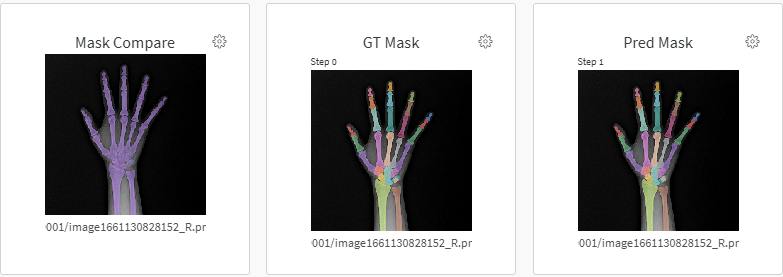

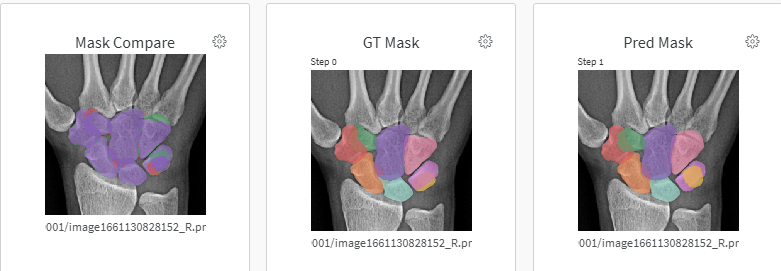

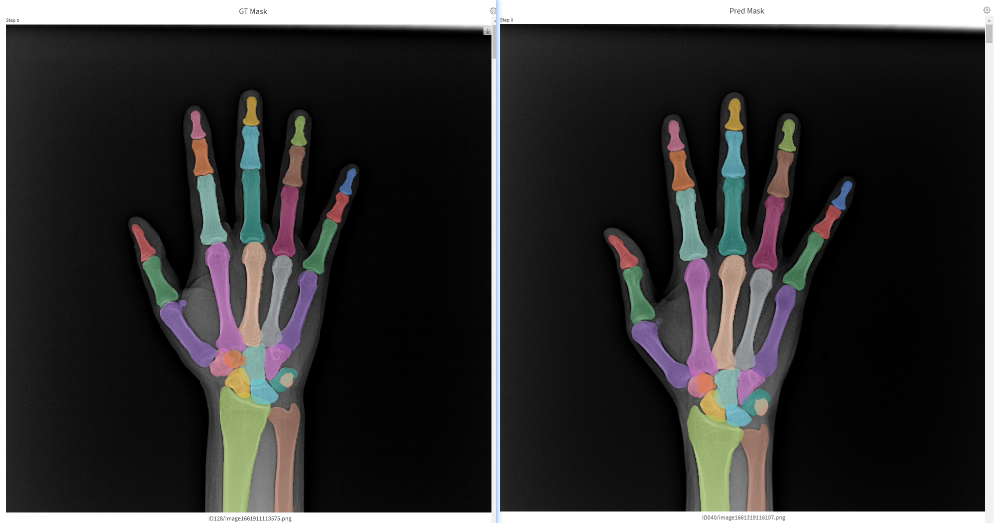